# Fraud Audit
    a.	Preprocess and clean if necessary.
    b.	Build a model predicting “Risk”. 
    c.	Remember to comment your code and give rationales for models, algorithms, and approaches. 


## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

## Load data

In [2]:
import pyodbc
import urllib
import sqlalchemy

'''connect to datahub'''

params_datahub = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))

In [3]:
df=pd.read_sql_table(r"audit_fraud_risk_data",engine_datahub)
df.head()

,Sector_score,LOCATION_ID,PARA_A,PARA_B,numbers,Money_Value,District_Loss,History,Score,Risk
0,3.89,23,4.18,2.50,5.0,3.38,2,0,2.4,1
1,3.89,6,0.00,4.83,5.0,0.94,2,0,2.0,0
2,3.89,6,0.51,0.23,5.0,0.00,2,0,2.0,0
3,3.89,6,0.00,10.80,6.0,11.75,2,0,4.4,1
4,3.89,6,0.00,0.08,5.0,0.00,2,0,2.0,0


## Exploratory Data Analysis(EDA)



### Check missing values and shape
Normally we need to clean the samples, i,e, impute missing values but in this case the data is pretty clean with no missing values. We also check the shape to make sure it matches the meta data info in the document. 

In [4]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sector_score   776 non-null    float64
 1   LOCATION_ID    776 non-null    object 
 2   PARA_A         776 non-null    float64
 3   PARA_B         776 non-null    float64
 4   numbers        776 non-null    float64
 5   Money_Value    775 non-null    float64
 6   District_Loss  776 non-null    int64  
 7   History        776 non-null    int64  
 8   Score          776 non-null    float64
 9   Risk           776 non-null    int64  
dtypes: float64(6), int64(3), object(1)
memory usage: 60.8+ KB


(None, (776, 10))

### Check Risk vs Non Risk ratio
The samples are balanced so we can use "Accuracy" metric to measure the performance of the model

<AxesSubplot:>

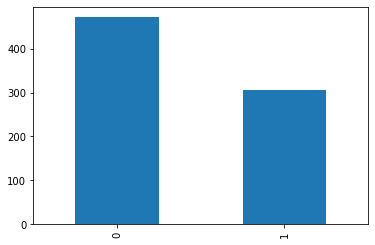

In [5]:
df.Risk.value_counts().plot(kind='bar')

### Describe the data

In [6]:

df.describe()

# from the "max" row we can see feature PARA_A, PARA_B,Money_Value,History have some potential outliers. 

,Sector_score,PARA_A,PARA_B,numbers,Money_Value,District_Loss,History,Score,Risk
count,776.000000,776.000000,776.000000,776.000000,775.000000,776.000000,776.000000,776.000000,776.000000
mean,20.184536,2.450194,10.799988,5.067655,14.137631,2.505155,0.104381,2.702577,0.393041
std,24.319017,5.678870,50.083624,0.264449,66.606519,1.228678,0.531031,0.858923,0.488741
min,1.850000,0.000000,0.000000,5.000000,0.000000,2.000000,0.000000,2.000000,0.000000
25%,2.370000,0.210000,0.000000,5.000000,0.000000,2.000000,0.000000,2.000000,0.000000
50%,3.890000,0.875000,0.405000,5.000000,0.090000,2.000000,0.000000,2.400000,0.000000
75%,55.570000,2.480000,4.160000,5.000000,5.595000,2.000000,0.000000,3.250000,1.000000
max,59.850000,85.000000,1264.630000,9.000000,935.030000,6.000000,9.000000,5.200000,1.000000


### Clip, i.e. assigns values outside boundary to boundary values, the data to deal with outliers. 
 Outliers may distort how we see the data. They contain information too so it's a tradeoff; we lose some info but gain a better big picture of the data.

In [7]:
# here we use quantile 0.01 as lower limit and 0.99 upper.
cols = df.drop(['LOCATION_ID','Risk'],axis=1).columns
df[cols]=df[cols].clip(lower=df[cols].quantile(0.01), upper=df[cols].quantile(0.99),axis=1)
df.describe()

,Sector_score,PARA_A,PARA_B,numbers,Money_Value,District_Loss,History,Score,Risk
count,776.000000,776.000000,776.000000,776.000000,775.000000,776.000000,776.000000,776.000000,776.000000
mean,20.184536,2.191895,9.143171,5.060567,10.405372,2.505155,0.083763,2.700000,0.393041
std,24.319017,3.412827,21.282609,0.207219,29.362539,1.228678,0.339934,0.852049,0.488741
min,1.850000,0.000000,0.000000,5.000000,0.000000,2.000000,0.000000,2.000000,0.000000
25%,2.370000,0.210000,0.000000,5.000000,0.000000,2.000000,0.000000,2.000000,0.000000
50%,3.890000,0.875000,0.405000,5.000000,0.090000,2.000000,0.000000,2.400000,0.000000
75%,55.570000,2.480000,4.160000,5.000000,5.595000,2.000000,0.000000,3.250000,1.000000
max,59.850000,17.950000,107.145000,6.125000,188.917400,6.000000,2.000000,4.800000,1.000000


### Histogram
Histogram groups numeric data into bins, displaying the bins as segmented columns and summarize the distribution of a univariate data set. 

C:\Users\ABC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


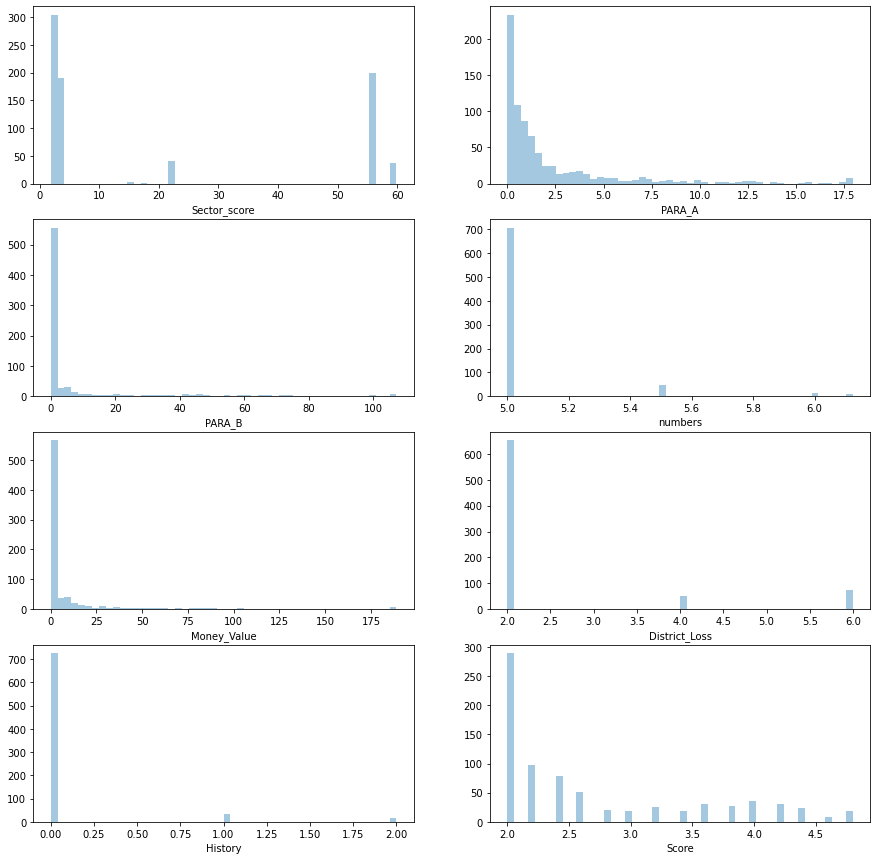

In [8]:
fig, ax = plt.subplots(4, 2, figsize=(15, 15))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.distplot(df[df.drop(['LOCATION_ID','Risk'],axis=1).columns[i*2+j]], ax=ax[i][j],kde_kws={'bw':0.1},bins=50,kde=False)

#### Explain the Histograms. 
None of the distributions seem normal. Sector_Score, numbers, History and District_Loss have values
that are concerntrated in a few bins. PARA_A, PARA_B, Money Value and Score are ditributed aross more bins.  

### Boxplot the data
Boxplot shows the shape of the distribution, its central value, and its variability

C:\Users\ABC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ABC\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\ABC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ABC\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.f

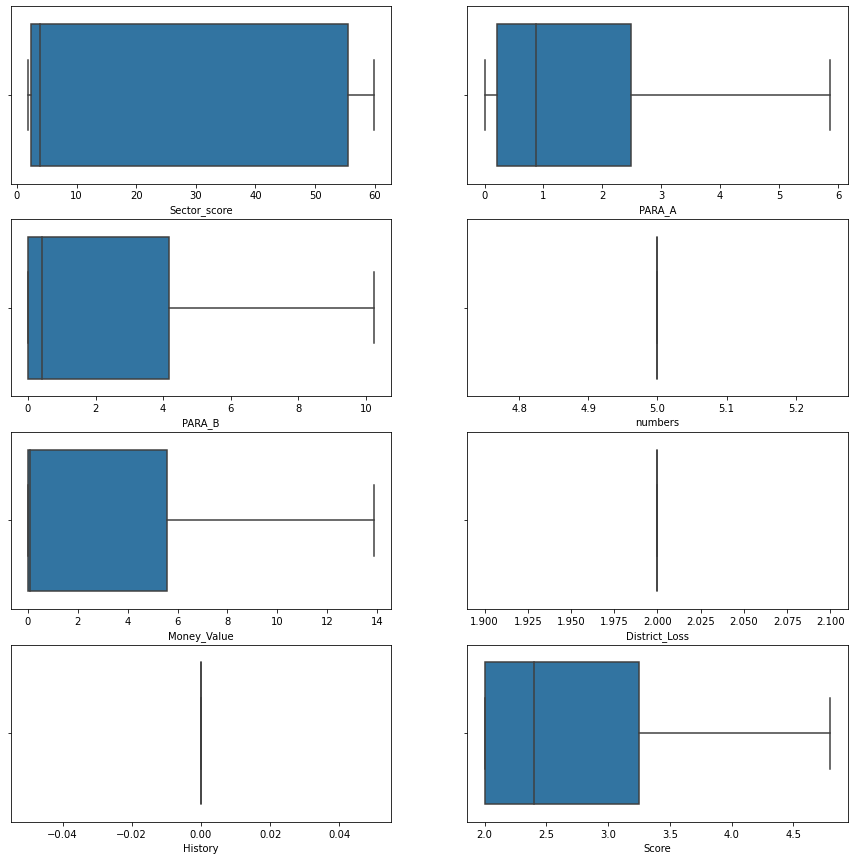

In [9]:
fig, ax = plt.subplots(4, 2, figsize=(15, 15))

#plot the features except LOCATION_ID and Risk
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.boxplot(df[df.drop(['LOCATION_ID','Risk'],axis=1).columns[i*2+j]], ax=ax[i][j],orient='v',showfliers=False)

#### Explain the Boxplots:
The boxplots tell similar story as the Histograms. None of the distributions seem normal.

### Correlation heatmap
Correlation heatmap allows us to see relations between features/attributes. The higher the absolute coefficient, the stronger the correlation is. 

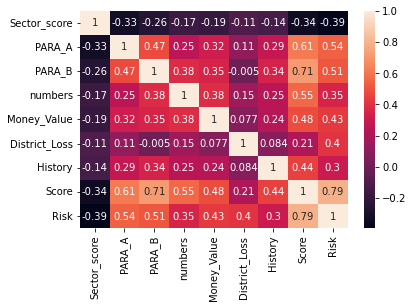

In [10]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Interpret the Correlation heatmap:
From the Correlation heatmap we can see that the attributes all have some correlations with Risk, the target variable we want to predict, which is a good sign. Among them Score, PARA_A, PARA_B, Monney_Value have stronger bonds with Risk, which suggest that they could be good predictors. Score( or District Score) has strong correlations with almost all attributes, which could suggest that it's a good indicator or index and the underlying methdology is good. History and District_Loss have weaker correlation with other attributes which suggest they are more independent. PARA_A and PARA_B have stronger correlation, which suggest they tend to go hand in hand, i.e., if you find discrepancy in report A, you may just find that in B too.     




## Data processing and cleaning

In [11]:
#check for missing values
df[df.isnull().any(axis=1)]

,Sector_score,LOCATION_ID,PARA_A,PARA_B,numbers,Money_Value,District_Loss,History,Score,Risk
642,55.57,4,0.23,0.0,5.0,NaN,2,0,2.0,0


In [12]:
#replace mnissing value with median, a better representation of the center of the data if it's not normally ditributed

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df['Money_Value']=imputer.fit_transform(df['Money_Value'].values.reshape(-1, 1))


In [13]:
#check if there is any missing values again
df[df.isnull().any(axis=1)]

,Sector_score,LOCATION_ID,PARA_A,PARA_B,numbers,Money_Value,District_Loss,History,Score,Risk


In [14]:
#Process the only categorical attribute
df.LOCATION_ID.unique()

array(['23', '6', '7', '8', '13', '37', '24', '3', '4', '14', '5', '20',
       '19', '21', '22', '9', '11', '12', '29', '30', '38', '31', '2',
       '32', '16', '33', '15', '36', '34', '18', '25', '39', '27', '35',
       '40', '41', '42', '1', '28', 'LOHARU', 'NUH', 'SAFIDON', '43',
       '44', '17'], dtype=object)

In [15]:
#convert to numbers. This way the text values will be converted to null.
df.LOCATION_ID=pd.to_numeric(df.LOCATION_ID, errors='coerce')

#replace null with mode 
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df.LOCATION_ID=imputer.fit_transform(df.LOCATION_ID.values.reshape(-1, 1))

#binning the numbers into 6 bins. 
bins = [-999,0, 9, 19, 29, 39, 49]
labels = [-1,0,1,2,3,4]
df['LOCATION_ID_binned'] = pd.cut(df['LOCATION_ID'], bins=bins, labels=labels).astype('int')
df=df.drop('LOCATION_ID',axis=1)
df.head()


,Sector_score,PARA_A,PARA_B,numbers,Money_Value,District_Loss,History,Score,Risk,LOCATION_ID_binned
0,3.89,4.18,2.50,5.0,3.38,2,0,2.4,1,2
1,3.89,0.00,4.83,5.0,0.94,2,0,2.0,0,0
2,3.89,0.51,0.23,5.0,0.00,2,0,2.0,0,0
3,3.89,0.00,10.80,6.0,11.75,2,0,4.4,1,0
4,3.89,0.00,0.08,5.0,0.00,2,0,2.0,0,0


In [16]:
#encode the attribute
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([each], axis=1)
    return df
df=one_hot(df,['LOCATION_ID_binned'])
df.head()

,Sector_score,PARA_A,PARA_B,numbers,Money_Value,District_Loss,History,Score,Risk,LOCATION_ID_binned_0,LOCATION_ID_binned_1,LOCATION_ID_binned_2,LOCATION_ID_binned_3,LOCATION_ID_binned_4
0,3.89,4.18,2.50,5.0,3.38,2,0,2.4,1,0,0,1,0,0
1,3.89,0.00,4.83,5.0,0.94,2,0,2.0,0,1,0,0,0,0
2,3.89,0.51,0.23,5.0,0.00,2,0,2.0,0,1,0,0,0,0
3,3.89,0.00,10.80,6.0,11.75,2,0,4.4,1,1,0,0,0,0
4,3.89,0.00,0.08,5.0,0.00,2,0,2.0,0,1,0,0,0,0


In [17]:
#double check the data to see if there is any missing values and all categorical attributes have been encoded.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Sector_score          776 non-null    float64
 1   PARA_A                776 non-null    float64
 2   PARA_B                776 non-null    float64
 3   numbers               776 non-null    float64
 4   Money_Value           776 non-null    float64
 5   District_Loss         776 non-null    int64  
 6   History               776 non-null    int64  
 7   Score                 776 non-null    float64
 8   Risk                  776 non-null    int64  
 9   LOCATION_ID_binned_0  776 non-null    uint8  
 10  LOCATION_ID_binned_1  776 non-null    uint8  
 11  LOCATION_ID_binned_2  776 non-null    uint8  
 12  LOCATION_ID_binned_3  776 non-null    uint8  
 13  LOCATION_ID_binned_4  776 non-null    uint8  
dtypes: float64(6), int64(3), uint8(5)
memory usage: 58.5 KB


## Create the function to train the model, test it, and visualize the results

In [18]:
def prediction(algorithm, training_x, testing_x, training_y, testing_y, cf, threshold_plot):
    #model
    algorithm.fit(training_x, training_y)
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
        
    print('Algorithm:', type(algorithm).__name__)
    print("\nClassification report:\n", classification_report(testing_y, predictions))
    print("Accuracy Score:", accuracy_score(testing_y, predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y, predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y, predictions) 
    print("Area under curve:", model_roc_auc,"\n")
    
    fpr, tpr, thresholds = roc_curve(testing_y, probabilities[:,1])
     
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix,
                        x = ["Risk 0", "Risk 1"],
                        y = ["Risk 0", "Risk 1"],
                        showscale = False, colorscale = "Picnic",
                        name = "Confusion matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr, y = tpr,
                        name = "Roc: " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'), width = 2))
    trace3 = go.Scatter(x = [0,1], y = [0,1],
                        line = dict(color = ('rgb(205, 12, 24)'), width = 2,
                        dash = 'dot'))
    
    if cf in ['coefficients', 'features']:
        if cf == 'coefficients':
            coefficients = pd.DataFrame(algorithm.coef_.ravel())
        elif cf == 'features':
            coefficients = pd.DataFrame(algorithm.feature_importances_)
        
        column_df = pd.DataFrame(training_x.columns.tolist())
        coef_sumry = (pd.merge(coefficients, column_df, left_index=True, 
                               right_index=True, how="left"))
        coef_sumry.columns = ["coefficients", "features"]
        coef_sumry = coef_sumry.sort_values(by = "coefficients", ascending=False)
        
        #plot coeffs
        trace4 = go.Bar(x = coef_sumry["features"], y = coef_sumry["coefficients"], 
                        name = "coefficients",
                        marker = dict(color = coef_sumry["coefficients"],
                                      colorscale = "Picnic",
                                      line = dict(width = .6, color = "black")
                                     )
                       )
        #subplots
        fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                                subplot_titles=('Confusion matrix',
                                                'Receiver operating characteristic',
                                                'Feature importances')
                           )  
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig.append_trace(trace4,2,1)
        fig['layout'].update(showlegend=False, title="Model performance",
                             autosize=False, height = 900, width = 800,
                             plot_bgcolor = 'rgba(240,240,240, 0.95)',
                             paper_bgcolor = 'rgba(240,240,240, 0.95)',
                             margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
        fig["layout"]["xaxis3"].update(dict(showgrid = True, tickfont = dict(size = 10), tickangle = 90))
        
    elif cf == 'None':
        #subplots
        fig = make_subplots(rows=1, cols=2,
                            subplot_titles=('Confusion matrix',
                                            'Receiver operating characteristic')
                           )
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig['layout'].update(showlegend=False, title="Model performance",
                         autosize=False, height = 500, width = 800,
                         plot_bgcolor = 'rgba(240,240,240,0.95)',
                         paper_bgcolor = 'rgba(240,240,240,0.95)',
                         margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))  
        
    py.iplot(fig)
    
    if threshold_plot == True: 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()


## Feed the parameters to the function created above
Split the data into train dataset and test dataset and use the Hyper Parameters obtained above to generate a Logistic Regression instance and execute the function.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.metrics import roc_auc_score, roc_curve,f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import statsmodels.api as sm
from yellowbrick.classifier import DiscriminationThreshold

#For better performance use MinMaxScaler to scale and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_x =pd.DataFrame(scaler.fit_transform(df[df.drop('Risk',axis=1).columns]),columns=df.drop('Risk',axis=1).columns)

#splitting the principal training dataset to subtrain and subtest datasets
x_train, x_test, y_train, y_test = train_test_split(df_x, df['Risk'], 
                                                    test_size = .25)

from sklearn.linear_model import LogisticRegression
import plotly.graph_objs as go # visualization
import plotly.offline as py # visualization
py.init_notebook_mode(connected=True) # visualization
import plotly.graph_objs as go # visualization
from plotly.subplots import make_subplots
import plotly.figure_factory as ff # visualization
import warnings
warnings.filterwarnings("ignore")
#Baseline model        
logit = LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                           verbose=0, warm_start=False)
prediction(logit, x_train, x_test, y_train, y_test, "coefficients", threshold_plot=False)

Algorithm: LogisticRegression

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       120
           1       0.99      0.97      0.98        74

    accuracy                           0.98       194
   macro avg       0.98      0.98      0.98       194
weighted avg       0.98      0.98      0.98       194

Accuracy Score: 0.9845360824742269
Area under curve: 0.9823198198198199 



# Interpret the results:
An Accuracy Score of 0.96 on Test data is a very good score with 1 being perfect 100% correct prediction. 
From the confusion Matrix we know that out of 194 predictions, only 7 mistake. Area under curve(True Positive/ False Positive), 
another model performance metric which often is used for unbalanced samples, is 0.965, also near perfect. 
The Feature Importance chart  suggests that  Money_Values, PARA_B, PARA_A, Score and District_Loss are more powerful predictors for Risk. 

Overall we have a very good model that can predict Risk.